References:

- https://github.com/JuliaReach/LazySets.jl/issues/1476

## Two dimensions

In [1]:
using LazySets, Plots

In [21]:
using LazySets.Approximations

n = 2
A = [Matrix{Float64}(I, n,n); -Matrix{Float64}(I, n,n)]
b = 0.1*ones(size(A,1))
hPoly = HPolyhedron(A, b)
minkowSum = hPoly ⊕ hPoly
oa = overapproximate(minkowSum, 1e-3)

HPolygon{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.2), HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0], 0.2), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.2), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 0.2)])

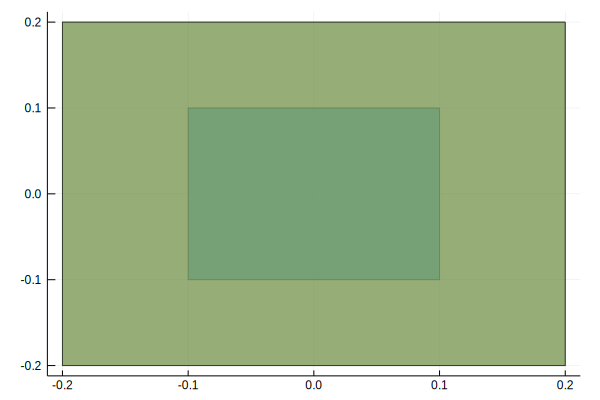

In [22]:
plot(hPoly1)
plot!(minkowSum)
plot!(oa)

## Three dimensions

We do not support epsilon-close approximation at the moment (see LazySets#969). However, if one is not interested in controlling the approximation error in Hausdorff distance (this is what we call epsilon-close approximation), the calculation of above can be handled in higher dims as well using template directions.

In [27]:
n = 3
A = [Matrix{Float64}(I, n,n); -Matrix{Float64}(I, n,n)]
b = 0.1*ones(size(A,1))
hPoly = HPolytope(A, b)
minkowSum = hPoly ⊕ hPoly 
dirs = SphericalDirections(10, 10)
oa = overapproximate(minkowSum, dirs)

HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 1.0], 0.2), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, -1.0], 0.2), HalfSpace{Float64,Array{Float64,1}}([0.34202, 0.0, 0.939693], 0.256343), HalfSpace{Float64,Array{Float64,1}}([0.642788, 0.0, 0.766044], 0.281766), HalfSpace{Float64,Array{Float64,1}}([0.866025, 0.0, 0.5], 0.273205), HalfSpace{Float64,Array{Float64,1}}([0.984808, 0.0, 0.173648], 0.231691), HalfSpace{Float64,Array{Float64,1}}([0.984808, 0.0, -0.173648], 0.231691), HalfSpace{Float64,Array{Float64,1}}([0.866025, 0.0, -0.5], 0.273205), HalfSpace{Float64,Array{Float64,1}}([0.642788, 0.0, -0.766044], 0.281766), HalfSpace{Float64,Array{Float64,1}}([0.34202, 0.0, -0.939693], 0.256343)  …  HalfSpace{Float64,Array{Float64,1}}([0.111619, -0.633022, -0.766044], 0.302137), HalfSpace{Float64,Array{Float64,1}}([0.0593912, -0.336824, -0.939693], 0.267182), HalfSpace{Float64,Array{Float64,1}}([0.262003, -0.21984

In [39]:
using Polyhedra, CDDLib
using Makie: mesh, mesh!
using AbstractPlotting: Automatic
using Polyhedra: Mesh

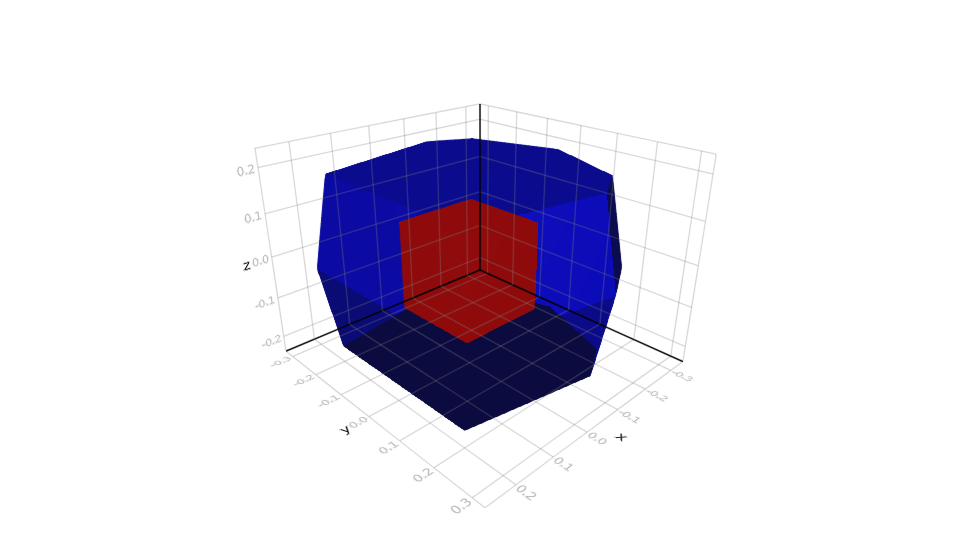

In [54]:
P_poly = polyhedron(oa, backend=CDDLib.Library())
P_poly_mesh = Mesh(P_poly)
mesh(P_poly_mesh, alpha=1.0, color=:blue, colormap=:viridis, colorrange=Automatic(), interpolate=false,
linewidth=1, overdraw=false, shading=true, transparency=true, visible=true)

mesh!(Mesh(polyhedron(hPoly, backend=CDDLib.Library())), alpha=1.0, color=:red, colormap=:viridis, colorrange=Automatic(), interpolate=false,
linewidth=1, overdraw=false, shading=true, transparency=true, visible=true)

## LazySets v1.14 + Polyhedra v0.5.2

In [221]:
using LazySets, Polyhedra, Random

function f1476(n, backend=Polyhedra.default_library(n, Float64))
    rng = MersenneTwister(n)
    
    P = convert(HPolytope, rand(Hyperrectangle, dim=n))
    # P = rand(HPolytope, dim=n, rng=rng) # slow for high dims

    A = rand(rng, n, n)
    AP = linear_map(A, P)
    minkowski_sum(AP, P, backend=backend) # concrete M-sum
end

f1476 (generic function with 2 methods)

In [226]:
res_default_library = []
for n in 2:5
    @time f1476(n)
    push!(res_default_library, f1476(n))
end

  0.001282 seconds (5.16 k allocations: 281.656 KiB)
  0.008583 seconds (33.59 k allocations: 2.646 MiB)
  0.071435 seconds (114.23 k allocations: 11.288 MiB, 18.36% gc time)
  0.590093 seconds (421.88 k allocations: 73.879 MiB, 6.07% gc time)


In [227]:
using CDDLib

res_cddlib = []
for n in 2:5
    lib = CDDLib.Library()
    @time f1476(n, lib)
    push!(res_cddlib, f1476(n, lib))
end

  0.000853 seconds (719 allocations: 56.922 KiB)
  0.007092 seconds (2.74 k allocations: 155.313 KiB)
  0.109957 seconds (8.35 k allocations: 438.922 KiB)
  2.761628 seconds (29.99 k allocations: 1.513 MiB)


## Overapproximation with random directions

In https://github.com/JuliaReach/LazySets.jl/pull/1503 we added uniform sampling of balls and spheres. This method can be used to overapproximate convex sets. Examples are presented next.

In [1]:
using LazySets, Polyhedra, Random, Plots
using LazySets.Approximations
import Distributions # required for LazySets.sample

using LazySets: _sample_unit_nsphere_muller!

┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/LazySets/NjrGc.ji for LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1184
┌ Warning: Package LazySets does not have CDDLib in its dependencies:
│ - If you have LazySets checked out for development and have
│   added CDDLib as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
└ Loading CDDLib into LazySets from project dependency, future warnings for LazySets are suppressed.


In [2]:
using Random

function data1476(n, backend=Polyhedra.default_library(n, Float64))
    rng = MersenneTwister(n)
    P = convert(HPolytope, rand(Hyperrectangle, dim=n))
    A = rand(rng, n, n)
    P, A
    # AP = linear_map(A, P)
    # minkowski_sum(AP, P, backend=backend) # concrete M-sum
end

data1476 (generic function with 2 methods)

In [3]:
n = 2 # dimension
P, A = data1476(n)

(HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,SingleEntryVector{Float64}}([1.0, 0.0], 0.863383), HalfSpace{Float64,SingleEntryVector{Float64}}([0.0, 1.0], 2.24162), HalfSpace{Float64,Array{Float64,1}}([-1.0, -0.0], 0.23343), HalfSpace{Float64,Array{Float64,1}}([-0.0, -1.0], -1.01436)]), [0.366796 0.210256; 0.523879 0.819338])

In [27]:
function LazySets.Approximations.overapproximate(X::LazySet{N}, dirs::Vector{Vector{N}}) where {N}
    halfspaces = Vector{LinearConstraint{N}}()
    sizehint!(halfspaces, length(dirs))
    H = HPolytope(halfspaces)
    for d in dirs
        addconstraint!(H, LinearConstraint(d, ρ(d, X)))
    end
    return H
end

In [28]:
# uniformly sample the n-sphere
nsamples = 100
dirs = Vector{Vector{Float64}}(undef, nsamples)
_sample_unit_nsphere_muller!(dirs, n, nsamples);

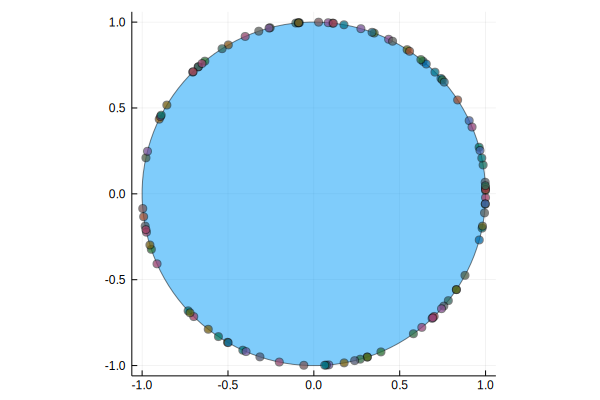

In [29]:
plot(Ball2(zeros(2), 1.0))
plot!([Singleton(di) for di in dirs], ratio=1)

In [30]:
# the set that we'd like to approximate
X = A * P ⊕ P

MinkowskiSum{Float64,LinearMap{Float64,HPolytope{Float64},Float64,Array{Float64,2}},HPolytope{Float64}}(LinearMap{Float64,HPolytope{Float64},Float64,Array{Float64,2}}([0.366796 0.210256; 0.523879 0.819338], HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,SingleEntryVector{Float64}}([1.0, 0.0], -0.036154), HalfSpace{Float64,SingleEntryVector{Float64}}([0.0, 1.0], 2.45657), HalfSpace{Float64,Array{Float64,1}}([-1.0, -0.0], 0.0545443), HalfSpace{Float64,Array{Float64,1}}([-0.0, -1.0], -1.152)])), HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,SingleEntryVector{Float64}}([1.0, 0.0], -0.036154), HalfSpace{Float64,SingleEntryVector{Float64}}([0.0, 1.0], 2.45657), HalfSpace{Float64,Array{Float64,1}}([-1.0, -0.0], 0.0545443), HalfSpace{Float64,Array{Float64,1}}([-0.0, -1.0], -1.152)]))

In [31]:
Xoa = overapproximate(X, dirs);

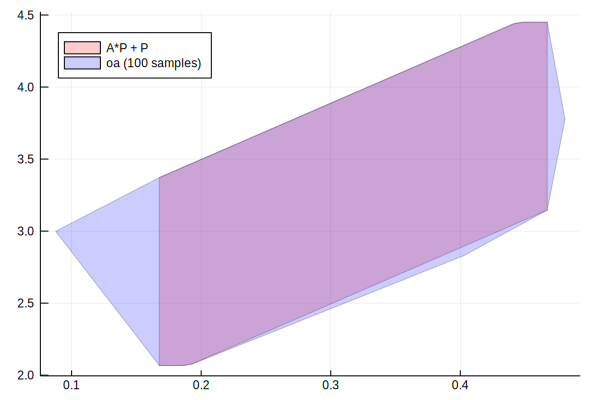

In [45]:
plot(X, color=:red, alpha=.2, lab="A*P + P")
plot!(Xoa, color=:blue, alpha=.2, lab="oa (100 samples)", legend=:topleft)

Adding more samples can be used to refine the set:

In [46]:
function refine(X, nsamples)
    n = LazySets.dim(X)
    dirs = Vector{Vector{Float64}}(undef, nsamples)
    _sample_unit_nsphere_muller!(dirs, n, nsamples)
    overapproximate(X, dirs)
end

refine (generic function with 1 method)

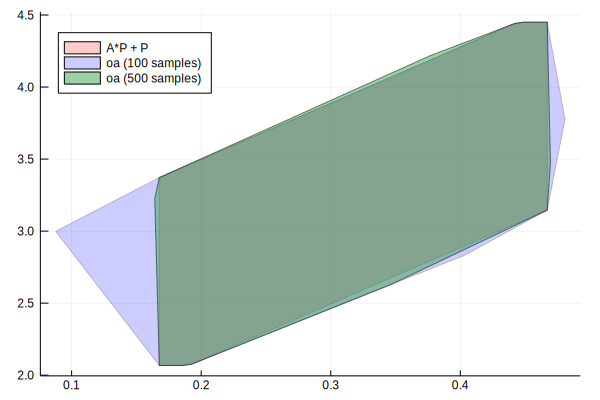

In [47]:
plot!(refine(X, 500), lab="oa (500 samples)")

In [87]:
# test in higher dimensions: refine and remove redundant constraints (optional)
function test_refine(n, k, remove_constraints=true)
    P, A = data1476(n)
    X = A * P ⊕ P
    res = Vector{HPolytope{Float64}}()
    for nsamples in k
        @time begin 
            Xoa = refine(X, nsamples)
            if remove_constraints
                remove_redundant_constraints!(Xoa)
            end
        end
        push!(res, Xoa)
    end
    return res
end

test_refine (generic function with 2 methods)

In [89]:
res = test_refine(8, [2, 10, 100, 1000], true);

  0.000520 seconds (646 allocations: 41.344 KiB)
  0.002141 seconds (3.19 k allocations: 239.156 KiB)
  0.040591 seconds (41.04 k allocations: 6.657 MiB, 7.34% gc time)
  3.200264 seconds (1.81 M allocations: 502.997 MiB, 3.50% gc time)


In [93]:
# refine without removing redundant constraints
res = test_refine(8, [2, 10, 100, 1000], false);

  0.000363 seconds (492 allocations: 30.203 KiB)
  0.001470 seconds (2.44 k allocations: 148.813 KiB)
  0.009939 seconds (24.31 k allocations: 1.449 MiB)
  0.135759 seconds (243.01 k allocations: 14.481 MiB, 3.74% gc time)


## Minkowski sum in H-representation

We consider an approach that can be found in [Minkowski addition of convex polytopes](https://pdfs.semanticscholar.org/7492/2769a31a4d6695f3ada51b05134f77b4fe5b.pdf) by Michal Kvasnica.

In [94]:
using LazySets, Polyhedra, Random, CDDLib

In [184]:
n = 2
P = linear_map(rand(n, n), convert(HPolytope, rand(Hyperrectangle, dim=n)));
Q = linear_map(rand(n, n), convert(HPolytope, rand(Hyperrectangle, dim=n)));

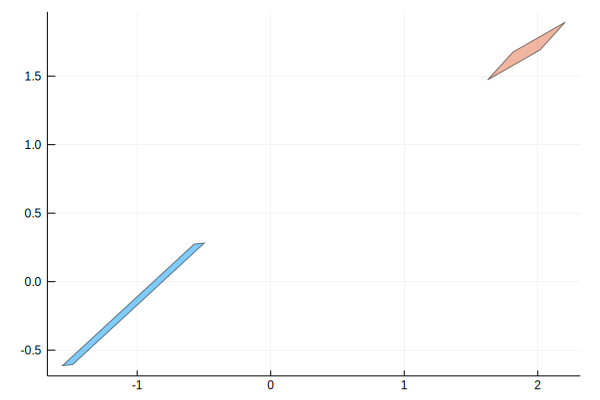

In [209]:
plot([P, Q])

In [210]:
A, b = tosimplehrep(P)
C, d = tosimplehrep(Q)

([-1.51935 2.72166; 2.62109 -2.4392; 1.51935 -2.72166; -2.62109 2.4392], [1.80467, 1.16054, -1.53858, -0.666978])

In [211]:
E = [zeros(size(A, 1), size(C, 2)) A; C -C]

8×4 Array{Float64,2}:
  0.0       0.0       2.13557   -2.37526
  0.0       0.0      -0.466973   5.06557
  0.0       0.0      -2.13557    2.37526
  0.0       0.0       0.466973  -5.06557
 -1.51935   2.72166   1.51935   -2.72166
  2.62109  -2.4392   -2.62109    2.4392 
  1.51935  -2.72166  -1.51935    2.72166
 -2.62109   2.4392    2.62109   -2.4392 

In [212]:
f = [b; d]

8-element Array{Float64,1}:
 -1.7303725062801112
  1.6586860343207308
  1.8758603943079377
  2.374008177971125 
  1.8046728168057604
  1.1605385639086714
 -1.5385767466333928
 -0.6669782531374271

In [213]:
PQ_2n = HPolytope(E, f)

HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 2.13557, -2.37526], -1.73037), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, -0.466973, 5.06557], 1.65869), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, -2.13557, 2.37526], 1.87586), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.466973, -5.06557], 2.37401), HalfSpace{Float64,Array{Float64,1}}([-1.51935, 2.72166, 1.51935, -2.72166], 1.80467), HalfSpace{Float64,Array{Float64,1}}([2.62109, -2.4392, -2.62109, 2.4392], 1.16054), HalfSpace{Float64,Array{Float64,1}}([1.51935, -2.72166, -1.51935, 2.72166], -1.53858), HalfSpace{Float64,Array{Float64,1}}([-2.62109, 2.4392, 2.62109, -2.4392], -0.666978)])

In [214]:
backend = CDDLib.Library()
_PQ_2n = polyhedron(PQ_2n, backend=backend)

Polyhedron CDDLib.Polyhedron{Float64}:
8-element iterator of Polyhedra.HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([0.0, 0.0, 2.13557, -2.37526], -1.7303725062801112)
 HalfSpace([0.0, 0.0, -0.466973, 5.06557], 1.6586860343207308)
 HalfSpace([0.0, 0.0, -2.13557, 2.37526], 1.8758603943079377)
 HalfSpace([0.0, 0.0, 0.466973, -5.06557], 2.374008177971125)
 HalfSpace([-1.51935, 2.72166, 1.51935, -2.72166], 1.8046728168057604)
 HalfSpace([2.62109, -2.4392, -2.62109, 2.4392], 1.1605385639086714)
 HalfSpace([1.51935, -2.72166, -1.51935, 2.72166], -1.5385767466333928)
 HalfSpace([-2.62109, 2.4392, 2.62109, -2.4392], -0.6669782531374271)

In [215]:
W = eliminate(_PQ_2n, 3:4, FourierMotzkin())

Polyhedron CDDLib.Polyhedron{Float64}:
40-element iterator of Polyhedra.HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([0.0, 0.0], 1.0)
 HalfSpace([0.0, 0.0], 1.0)
 HalfSpace([-0.0, -0.0], 1.0)
 HalfSpace([-0.0, -0.0], 1.0)
 HalfSpace([3.16114, -2.94177], -1.0)
 HalfSpace([1.48233, -1.6487], -1.0)
 HalfSpace([7.18914, -5.18558], 1.0)
 HalfSpace([3.63119, -3.37921], -1.0)
 HalfSpace([-0.0, -0.0], 1.0)
 HalfSpace([1.67189, -1.85953], -1.0)
 HalfSpace([0.0, 0.0], 1.0)
 HalfSpace([1.0, -1.79133], -1.3654263635879653)
 HalfSpace([-1.0, 1.79133], 3.076365743890262)
 HalfSpace([-1.07457, 1.0], 1.5860749893117199)
 HalfSpace([-1.36025, 1.26586], 1.0)
 HalfSpace([-15.4059, -0.0], -1.0)
 HalfSpace([2.35564, -2.19218], 1.0)
 HalfSpace([1.0, -1.44667], -1.0376440186048443)
 HalfSpace([-1.0, 10.8477], 29.691164520761607)
 HalfSpace([-0.0, 1.84731e-16], 1.0)
 HalfSpace([-1.28848, 1.19907], 1.0)
 HalfSpace([1.0, -10.8477], -7.066147501828203)
 HalfSpace([1.70042, -3.04602], -1.0)
 HalfSpace([1.0, -1

In [216]:
Wpoly = HPolytope(W);

In [217]:
length(constraints_list(Wpoly))

40

In [218]:
remove_redundant_constraints!(Wpoly)

true

In [219]:
length(constraints_list(Wpoly))

12

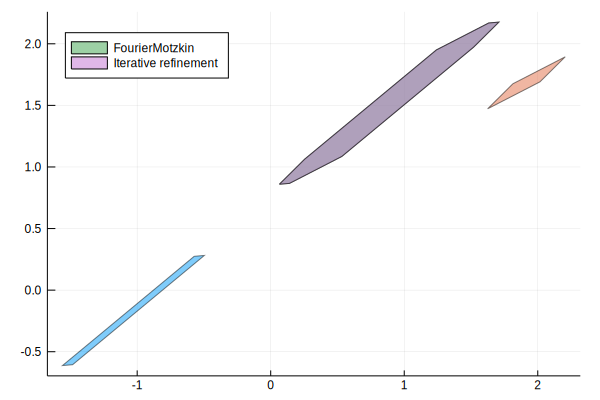

In [220]:
plot!(Wpoly, lab="FourierMotzkin")
plot!(P ⊕ Q, lab="Iterative refinement", legend=:topleft)

### Test

For the implementation see PR https://github.com/JuliaReach/LazySets.jl/pull/1508.

In [46]:
using LazySets, Polyhedra, CDDLib

function minkowski_sum(P, Q;
                       backend=CDDLib.Library(),
                       algorithm=Polyhedra.BlockElimination(),
                       prune=true)

    
    A, b = tosimplehrep(constraints_list(P))
    C, d = tosimplehrep(constraints_list(Q))
    mP, nP = size(A)
    mQ, nQ = size(C)
    E = [zeros(Float64, mP, nQ) A; C -C]
    f = [b; d]
    PQ = HPolytope(E, f)
    PQ_cdd = polyhedron(PQ, backend=backend)
    W = Polyhedra.eliminate(PQ_cdd, nP+1:2nP, algorithm)
    W = HPolytope(W)
    if prune
        remove_redundant_constraints!(W)
    end
    return W
end

minkowski_sum (generic function with 4 methods)

In [51]:
@time minkowski_sum(rand(Hyperrectangle, dim=8), rand(Hyperrectangle, dim=8), algorithm=BlockElimination())

  0.010841 seconds (11.99 k allocations: 780.802 KiB)


HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 0.352863), HalfSpace{Float64,Array{Float64,1}}([-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 2.25524), HalfSpace{Float64,Array{Float64,1}}([-0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 2.56554), HalfSpace{Float64,Array{Float64,1}}([-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 0.179867), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], 2.90416), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], 2.63717), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0], 4.47749), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], 1.25237), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0], 1.43796), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0,

In [52]:
@time minkowski_sum(rand(Hyperrectangle, dim=8), rand(Hyperrectangle, dim=8), algorithm=FourierMotzkin())

  0.002218 seconds (4.97 k allocations: 396.008 KiB)


HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.0], 1.07981), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 4.66565), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.0, -0.0], 1.86501), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.19175, 0.0], -1.0), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -0.0, -0.0, -1.0, -0.0, -0.0], 5.32162), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 2.55597), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0], 5.72924), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 1.12011, 0.0, 0.0, 0.0], 1.0), HalfSpace{Float64,Array{Float64,1}}([-0.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], 3.37606), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 5.4002, 0.0, 0.0, 0.0, 0.0], -

In [55]:
function test_msum_hrep(n; prune=true, algorithm=BlockElimination())
    P, A = data1476(n)
    res = Vector{HPolytope{Float64}}()
    @time begin 
        X = minkowski_sum(A * P, P, algorithm=algorithm) # concrete M-sum in Hrep
        if prune
            remove_redundant_constraints!(X)
        end
    end
    return res
end

test_msum_hrep (generic function with 3 methods)

In [57]:
res = test_msum_hrep(4, prune=true, algorithm=BlockElimination());

  0.079692 seconds (66.89 k allocations: 7.518 MiB, 21.00% gc time)


In [60]:
# res = test_msum_hrep(4, prune=true, algorithm=FourierMotzkin()); # slow

In [64]:
res = test_msum_hrep(5, prune=true, algorithm=BlockElimination());

  0.699060 seconds (421.64 k allocations: 85.241 MiB, 6.32% gc time)


In [61]:
res = test_msum_hrep(6, prune=true, algorithm=BlockElimination());

 22.340963 seconds (8.74 M allocations: 1.326 GiB, 1.72% gc time)


In [62]:
res = test_msum_hrep(7, prune=true, algorithm=BlockElimination());

143.632793 seconds (139.52 M allocations: 21.234 GiB, 3.29% gc time)


In [66]:
res = test_msum_hrep(8, prune=true, algorithm=BlockElimination()); # slow

InterruptException: InterruptException: